<h1 style="color:#ff00aa; padding:20px; text-align:center; font-size:28px; border-top-left-radius:10px; border-top-right-radius:10px;background:#170052; border:2px solid #0bbdb7; margin:0px;">Brest Cancer Detection Using ML</h1>
<img src="https://www.silabs.com/content/dam/siliconlabs/images/solutions/ai-ml/ai-ml-banner.png" width=100% height=auto style="margin:0px;">


# initial import

In [143]:
# importing 
import numpy as np
import os
import time
import pickle

# neural network packages
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 
import keras

# mechine learning pakages
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report


# data visualizing pakages
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

# image processing
import cv2
import glob
import imageio
try:
    import imutils
except:
    !pip install imutils
    import imutils
 


# GPU Info 
try:
    import GPUtil
except:
    !pip install GPUtil
    import GPUtil

# warning
import warnings
warnings.filterwarnings("ignore")

In [68]:
# check physical computing devices
device=tf.config.experimental.list_physical_devices()
for i in device:
    print(i)
if len(device)>1:
    # find GPU details
    print("="*20, "GPU Details", "="*20)
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(gpu_id,gpu.name, gpu.driver,gpu.memoryTotal,gpu.temperature)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


### Contour croping of image
> the function crop_contour_img() crop the images and remove the unnessary portion of the image and filter for better >  > > result. It also plot the after-before effect. just set the plot=True.make sure you have inastalled requirements.
#### parameters

image : type-cv2image : get the matrix type image<br>
plot : binary data [True / False] : permission to plot after-before of image.

In [69]:
def crop_contour_img(image, plot=False):
    import matplotlib.pyplot as plt
    import cv2
    import numpy
    import imutils
    import imageio
    
    grayscale=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale=cv2.GaussianBlur(grayscale,(5,5),0)
    threshhold_image=cv2.threshold(grayscale, 50, 255, cv2.THRESH_BINARY)[1]
    threshhold_image=cv2.erode(threshhold_image,None,iterations=3)
    threshhold_image=cv2.dilate(threshhold_image,None,iterations=3)
    
    
    countour=cv2.findContours(threshhold_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    countour=imutils.grab_contours(countour)
    c=max(countour, key=cv2.contourArea)
    
    extreme_pnts_left=tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right=tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top=tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot=tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1],extreme_pnts_left[0]:extreme_pnts_right[0]]
    new_image= cv2.threshold(new_image, 65, 255, cv2.THRESH_BINARY,cv2.CHAIN_APPROX_SIMPLE)[1]
    new_image=cv2.bitwise_not(new_image)
    
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("original image")
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("processed image")
        plt.show()
        
    return new_image

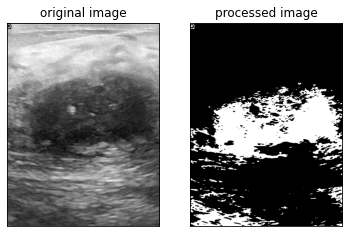

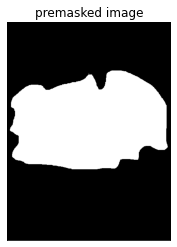

In [70]:
# testing
path = "D:/Image_datasets/breast_cancer_image_dataset/Dataset_BUSI_with_GT"
example_image=cv2.imread(path+"/malignant/malignant (1).png")
img=crop_contour_img(example_image,True)
premasked_image=cv2.imread(path+"/malignant/malignant (1)_mask.png")
# premasked_image=cv2.bitwise_not(premasked_image)
plt.imshow(premasked_image)
plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
plt.title("premasked image")
print()

## Load images

In [71]:
# root directory path for image dataset
path = "D:/Image_datasets/breast_cancer_image_dataset/Dataset_BUSI_with_GT/"
# make sure root folder contains segmanted data folders"


# view directory tree
def tree_printer(root):
    print("🗁",root)
    for root, dirs, files in os.walk(root):
        for d in dirs:
            print(" |- 🗁",d," "*2+"象",len(os.listdir(os.path.join(root, d))),"items")
            
tree_printer(path)

🗁 D:/Image_datasets/breast_cancer_image_dataset/Dataset_BUSI_with_GT/
 |- 🗁 benign   象 891 items
 |- 🗁 malignant   象 421 items
 |- 🗁 normal   象 266 items


In [72]:
def load_images(path,type="png",target=0,images=[],result=[]):
    for filepath in os.listdir(path):
        if filepath.split(".")[-1].lower()=="png" and "mask" in filepath:
            img=cv2.imread(path+"/"+filepath)
#             img=crop_contour_img(img)
            img=cv2.resize(img,(128,128))
            img=np.array(img)
            images.append(img)
            result.append(encoder.transform([[target]]).toarray())
    
    return [images,result]

def show_image(datasets,num=4):  
    for i in range(num**2):
        plt.subplot(num, num, i+1)
        plt.imshow(datasets[i])
        plt.title(i+1)
        plt.axis('off')

        
def prepare_image_target(path,result):
    img=cv2.imread(path)
    img=crop_contour_img(img,True)
    img=cv2.resize(img,(128,128))
    img=np.array(img)
    img=img.reshape(1,128,128,3)
    img=img.reshape(-1)
    if result=="yes":
        return [img,[1]]
    else:
        return [img,[0]]
    
def analysis_pred(pred,org):
    accurate=0
    for i in range(len(pred)):
        print(i,")  predicted :",pred[i],end=" | ")
        print("Original :",org[i][0], end=" | ")
        if pred[i]==org[i]:
            print("accurate : Yes.")
            accurate+=1
        else:
            print("accurate : No.")
    print("\n"+("-")*10+"score"+("-")*10)
    print("accurate=",accurate,"/",len(pred)," | accuracy=",round((accurate/len(pred)*100),3),"%") 


In [73]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

OneHotEncoder()

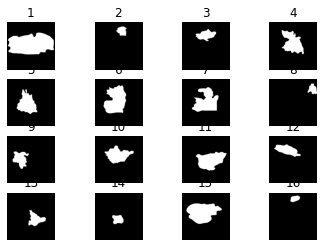

In [74]:
# yes
yes_images,yes_result=load_images(path+"/malignant",target=0,images=[],result=[])
# print(images.shape)
show_image(yes_images)
# print(result)


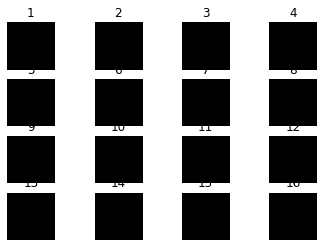

In [75]:
# no
no_images,no_result=load_images(path+"/normal",target=1,images=[],result=[])
# print(images.shape)
show_image(no_images)
# print(result)


In [76]:
images=yes_images+no_images
result=yes_result+no_result

data=np.array(images)
print(data.shape)
print(len(result))

(344, 128, 128, 3)
344


In [77]:
target=np.array(result)
target=target.reshape(len(result),2)
print(target.shape)
# print(target)

(344, 2)


In [78]:
new_target=[]
for i in target:
    
    if i[0]==1.:
        new_target.append([1])
    else:
        new_target.append([0])

new_target=np.array(new_target)
# new_target

In [79]:
new_data=[]
for i in data:
    new_data.append(i.reshape(-1))

new_data=np.array(new_data)


# breast cancer Detection using Binary Decision Tree

> next cells are for decision tree.<br>
#### step 1 - import dependencies for DT
#### step 2 - get the image and filter them
#### step 3 - preprocessing 
#### step 4 - model build and fitting
#### step 5 - predict and analysis 

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
x_train,x_test,y_train,y_test=train_test_split(new_data, new_target, test_size=0.2, shuffle=True, random_state=0)
x_train.shape,y_test.shape

((275, 49152), (69, 1))

In [82]:
clf = DecisionTreeClassifier(criterion="gini",min_samples_split=10,max_features=5)

In [83]:
# tree_para = {'criterion':['gini','entropy'],"min_samples_split":[1,10],"max_features":np.arange(1,10)}
# clf = GridSearchCV(clf, tree_para, cv=5)

In [84]:
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_features=5, min_samples_split=10)

In [85]:
# clf.best_params_       
# {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 10}

In [86]:
accuracy=clf.score(x_test,y_test)
accuracy

0.9710144927536232

In [87]:
y_pred=clf.predict(x_test)

In [88]:
y_pred

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0])

In [89]:
analysis_pred(y_pred,y_test)

0 )  predicted : 1 | Original : 1 | accurate : Yes.
1 )  predicted : 1 | Original : 1 | accurate : Yes.
2 )  predicted : 1 | Original : 1 | accurate : Yes.
3 )  predicted : 0 | Original : 0 | accurate : Yes.
4 )  predicted : 1 | Original : 1 | accurate : Yes.
5 )  predicted : 0 | Original : 0 | accurate : Yes.
6 )  predicted : 1 | Original : 1 | accurate : Yes.
7 )  predicted : 0 | Original : 0 | accurate : Yes.
8 )  predicted : 0 | Original : 0 | accurate : Yes.
9 )  predicted : 1 | Original : 1 | accurate : Yes.
10 )  predicted : 1 | Original : 1 | accurate : Yes.
11 )  predicted : 0 | Original : 0 | accurate : Yes.
12 )  predicted : 1 | Original : 1 | accurate : Yes.
13 )  predicted : 0 | Original : 0 | accurate : Yes.
14 )  predicted : 0 | Original : 0 | accurate : Yes.
15 )  predicted : 1 | Original : 1 | accurate : Yes.
16 )  predicted : 0 | Original : 1 | accurate : No.
17 )  predicted : 0 | Original : 0 | accurate : Yes.
18 )  predicted : 1 | Original : 1 | accurate : Yes.
19 )

Text(0.5, 1.0, 'breast cancer detection with DT   |    accuracy : 97.1')

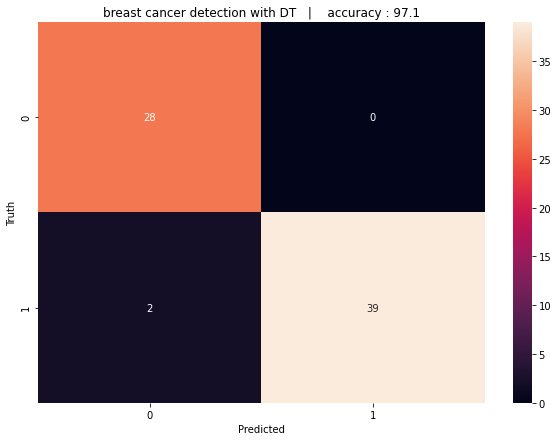

In [90]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with DT   |    accuracy : "+str(round(accuracy,4)*100))

In [91]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.95      0.97        41

    accuracy                           0.97        69
   macro avg       0.97      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69



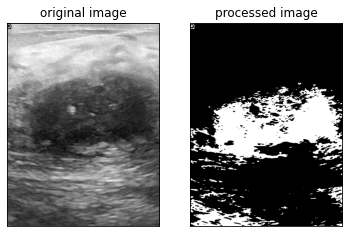

0 )  predicted : 1 | Original : 1 | accurate : Yes.

----------score----------
accurate= 1 / 1  | accuracy= 100.0 %


In [92]:
test_img,test_target=prepare_image_target(path+"/malignant/malignant (1).png","yes")
test_img.shape
test_pred=clf.predict([test_img])
# print(test_pred,test_target)
analysis_pred(test_pred,[test_target])

# breast cancer Detection using K nearest neabour algorithm

> next cells are for KNN.<br>
#### step 1 - import dependencies for KNN
#### step 2 - get the image and filter them
#### step 3 - preprocessing 
#### step 4 - model build and fitting
#### step 5 - predict and analysis 

In [93]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
# tree_para = {"weights":('uniform', 'distance'),"n_neighbors":[1,30]}
# knn_clf = GridSearchCV(KNeighborsClassifier(), tree_para, cv=5).fit(x_train,y_train)
# print(knn_clf.score(x_test,y_test))
# print(knn_clf.best_params_)
# {'n_neighbors': 1, 'weights': 'uniform'}

In [95]:
knn = KNeighborsClassifier(n_neighbors=1,weights="uniform")
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [96]:
accuracy=knn.score(x_test,y_test)
accuracy

0.9420289855072463

In [97]:
y_pred=knn.predict(x_test)

In [98]:
analysis_pred(y_pred,y_test)

0 )  predicted : 1 | Original : 1 | accurate : Yes.
1 )  predicted : 1 | Original : 1 | accurate : Yes.
2 )  predicted : 1 | Original : 1 | accurate : Yes.
3 )  predicted : 0 | Original : 0 | accurate : Yes.
4 )  predicted : 0 | Original : 1 | accurate : No.
5 )  predicted : 0 | Original : 0 | accurate : Yes.
6 )  predicted : 1 | Original : 1 | accurate : Yes.
7 )  predicted : 0 | Original : 0 | accurate : Yes.
8 )  predicted : 0 | Original : 0 | accurate : Yes.
9 )  predicted : 1 | Original : 1 | accurate : Yes.
10 )  predicted : 1 | Original : 1 | accurate : Yes.
11 )  predicted : 0 | Original : 0 | accurate : Yes.
12 )  predicted : 1 | Original : 1 | accurate : Yes.
13 )  predicted : 0 | Original : 0 | accurate : Yes.
14 )  predicted : 0 | Original : 0 | accurate : Yes.
15 )  predicted : 1 | Original : 1 | accurate : Yes.
16 )  predicted : 0 | Original : 1 | accurate : No.
17 )  predicted : 0 | Original : 0 | accurate : Yes.
18 )  predicted : 1 | Original : 1 | accurate : Yes.
19 ) 

Text(0.5, 1.0, 'breast cancer detection with DT   |    accuracy : 94.19999999999999')

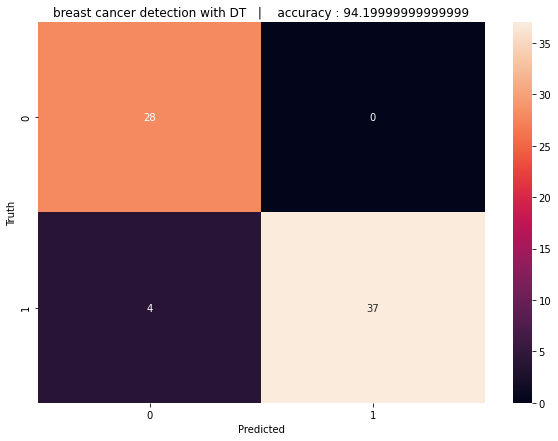

In [99]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with DT   |    accuracy : "+str(round(accuracy,4)*100))

In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       1.00      0.90      0.95        41

    accuracy                           0.94        69
   macro avg       0.94      0.95      0.94        69
weighted avg       0.95      0.94      0.94        69



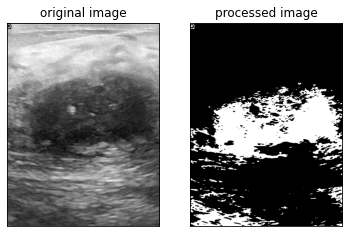

0 )  predicted : 1 | Original : 1 | accurate : Yes.

----------score----------
accurate= 1 / 1  | accuracy= 100.0 %


In [101]:
test_img,test_target=prepare_image_target(path+"/malignant/malignant (1).png","yes")
test_img.shape
test_pred=knn.predict([test_img])
# print(test_pred,test_target)
analysis_pred(test_pred,[test_target])

# breast cancer Detection using Gaussian Naive Bayes (GaussianNB)

In [102]:
from sklearn.naive_bayes import GaussianNB

In [103]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [104]:
accuracy=gnb.score(x_test,y_test)
accuracy

1.0

In [105]:
y_pred=gnb.predict(x_test)

Text(0.5, 1.0, 'breast cancer detection with DT   |    accuracy : 100.0')

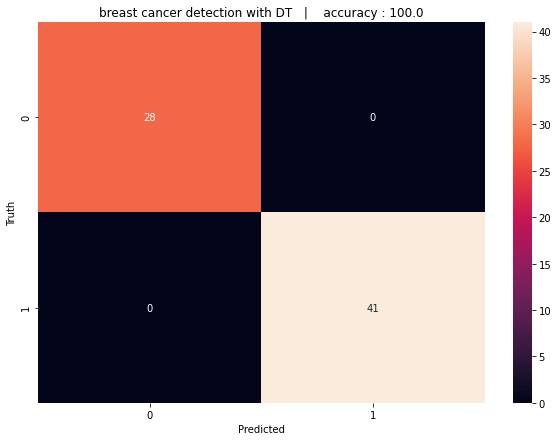

In [106]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with DT   |    accuracy : "+str(round(accuracy,4)*100))

In [107]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        41

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



# breast cancer Detection using Random Forest classifier

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
rf = RandomForestClassifier(bootstrap=False,max_features=1,min_samples_split=2,n_estimators=100)

In [110]:

rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_features=1)

In [111]:
accuracy=rf.score(x_test,y_test)
accuracy

0.9710144927536232

In [112]:
y_pred=rf.predict(x_test)
y_pred=np.round(y_pred)
y_pred

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0])

Text(0.5, 1.0, 'breast cancer detection with    |    accuracy : 97.1')

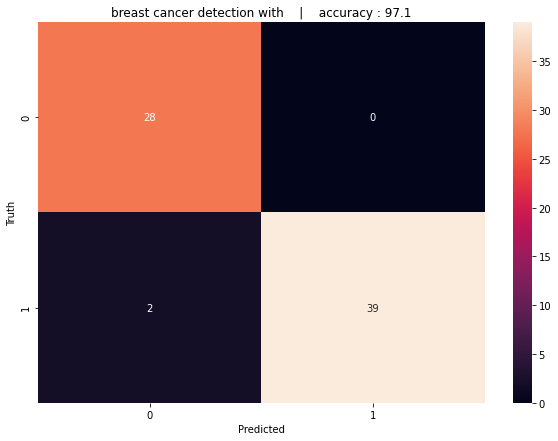

In [113]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with    |    accuracy : "+str(round(accuracy,4)*100))

In [114]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.95      0.97        41

    accuracy                           0.97        69
   macro avg       0.97      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69



# breast cancer Detection using Support Vector Machine(C-Support Vector Classification)

In [115]:
from sklearn import svm

In [116]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10],"degree":[1,10],"gamma":('scale', 'auto')}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(x_train,y_train)
# print(clf.best_params_)
# print(clf.score(x_test,y_test))
# {'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [117]:
svc = svm.SVC(C=10,degree=1,gamma="auto",kernel="rbf")

In [118]:
svc.fit(x_train,y_train)

SVC(C=10, degree=1, gamma='auto')

In [119]:
accuracy=svc.score(x_test,y_test)
accuracy

1.0

In [120]:
y_pred=gnb.predict(x_test)

Text(0.5, 1.0, 'breast cancer detection with DT   |    accuracy : 100.0')

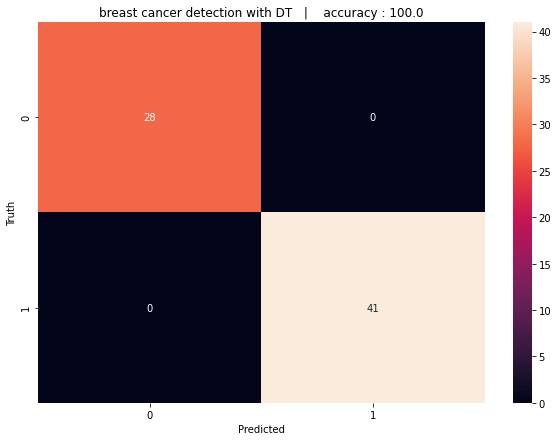

In [121]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with DT   |    accuracy : "+str(round(accuracy,4)*100))

In [122]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        41

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



# breast cancer Detection using K-means clustering

In [123]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics


In [124]:
total_clusters = len(np.unique(y_test))

In [125]:
kmeans = MiniBatchKMeans(n_clusters = total_clusters,init="random")

In [126]:
kmeans.fit(x_train)

MiniBatchKMeans(init='random', n_clusters=2)

In [127]:
y_pred = kmeans.predict(x_test)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1])

In [128]:
centroids = kmeans.cluster_centers_
labels= kmeans.labels_

In [129]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.36      0.39      0.38        41

    accuracy                           0.23        69
   macro avg       0.18      0.20      0.19        69
weighted avg       0.22      0.23      0.22        69



# breast cancer Detection using logisticRegression

# breast cancer Detection using CNN

In [130]:
def get_model():
    model = keras.Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
    model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
    
    return model
model=get_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)       

In [131]:
print(data.shape,target.shape)
x_train,x_test,y_train,y_test=train_test_split(data, target, test_size=0.2, shuffle=True, random_state=0)


(344, 128, 128, 3) (344, 2)


In [132]:
cnn = model.fit(x_train, y_train, epochs = 15, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/15
7/7 [==============================] - 9s 1s/step - loss: 0.5040 - val_loss: 0.0896
Epoch 2/15
7/7 [==============================] - 9s 1s/step - loss: 0.0082 - val_loss: 0.0205
Epoch 3/15
7/7 [==============================] - 8s 1s/step - loss: 0.0000e+00 - val_loss: 2.9585e-04
Epoch 4/15
7/7 [==============================] - 9s 1s/step - loss: 0.0000e+00 - val_loss: 3.2411e-06
Epoch 5/15
7/7 [==============================] - 8s 1s/step - loss: 0.0000e+00 - val_loss: 4.8375e-08
Epoch 6/15
7/7 [==============================] - 8s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/15
7/7 [==============================] - 9s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/15
7/7 [==============================] - 9s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/15
7/7 [==============================] - 9s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/15
7/7 [==============================] - 9s 1s/step - loss: 0.0000e+00 - val_lo

In [133]:
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 90ms/step - loss: 0.0000e+00


0.0

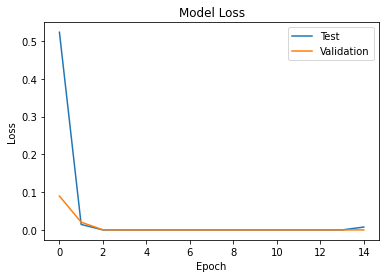

In [134]:
# plotting loss
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [135]:
def analysis_nn_pred(pred,org,tags=[1,0]):
    accurate=0
    for i in range(len(pred)):
        print(i,")  predicted :",tags[np.array(pred[i]).argmax()],end=" | ")
        print("Original :",tags[np.array(org[i]).argmax()], end=" | ")
        if np.array(pred[i]).argmax()==np.array(org[i]).argmax():
            print("accurate : Yes.")
            accurate+=1
        else:
            print("accurate : No.")
    print("\n"+("-")*10+"score"+("-")*10)
    print("accurate=",accurate,"/",len(pred)," | accuracy=",round((accurate/len(pred)*100),3),"%")
    return (accurate/len(pred)*100)
        

In [136]:
res = model.predict_on_batch(x_test)

# index 0 : no tumor
# index 1 : tumor
accuracy=analysis_nn_pred(res,y_test,["tumor","No tumor"])


0 )  predicted : tumor | Original : tumor | accurate : Yes.
1 )  predicted : tumor | Original : tumor | accurate : Yes.
2 )  predicted : tumor | Original : tumor | accurate : Yes.
3 )  predicted : No tumor | Original : No tumor | accurate : Yes.
4 )  predicted : tumor | Original : tumor | accurate : Yes.
5 )  predicted : No tumor | Original : No tumor | accurate : Yes.
6 )  predicted : tumor | Original : tumor | accurate : Yes.
7 )  predicted : No tumor | Original : No tumor | accurate : Yes.
8 )  predicted : No tumor | Original : No tumor | accurate : Yes.
9 )  predicted : tumor | Original : tumor | accurate : Yes.
10 )  predicted : tumor | Original : tumor | accurate : Yes.
11 )  predicted : No tumor | Original : No tumor | accurate : Yes.
12 )  predicted : tumor | Original : tumor | accurate : Yes.
13 )  predicted : No tumor | Original : No tumor | accurate : Yes.
14 )  predicted : No tumor | Original : No tumor | accurate : Yes.
15 )  predicted : tumor | Original : tumor | accurate

Text(0.5, 1.0, 'breast cancer detection with CNN   |    accuracy : 100.0')

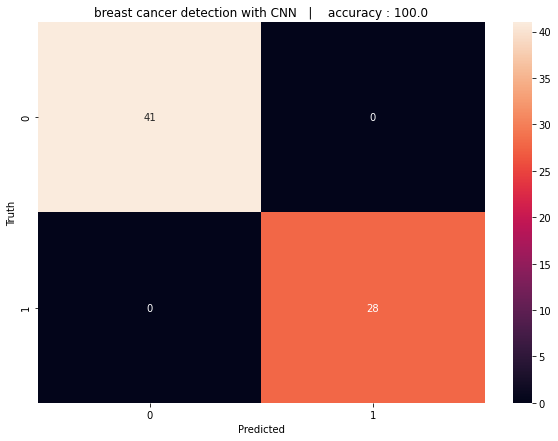

In [137]:
y_pred=model.predict(x_test)
y_pred_labels=[np.argmax(i) for i in y_pred]
y_test_labels=[np.argmax(i) for i in y_test]
cm=tf.math.confusion_matrix(labels=y_test_labels,predictions=y_pred_labels)

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("breast cancer detection with CNN   |    accuracy : "+str(round(accuracy,4)))

In [138]:
print(classification_report(y_test_labels,y_pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        28

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [139]:
def prepare_image_target(path,result):
    img=cv2.imread(path)
    img=crop_contour_img(img,True)
    img=cv2.resize(img,(128,128))
    img=np.array(img)
    img=img.reshape(1,128,128,3)
    if result=="yes":
        return [img,np.array([1.,0.])]
    else:
        return [img,np.array([[0.,1.]])]
    
    
    

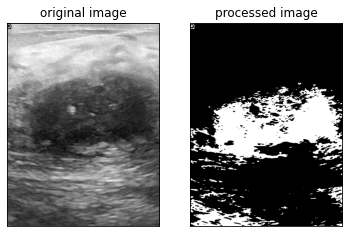

[[1. 0.]] [1. 0.]
0 )  predicted : tumor | Original : tumor | accurate : Yes.

----------score----------
accurate= 1 / 1  | accuracy= 100.0 %


100.0

In [140]:
test_img,test_target=prepare_image_target(path+"/malignant/malignant (1).png","yes")
test_pred=model.predict_on_batch(test_img)
print(test_pred,test_target)
analysis_nn_pred(test_pred,test_target,["tumor","No tumor"])

In [162]:
def storeData(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.h5")
    
from keras.models import model_from_json
def loaddata():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

In [163]:
storeData(model)

In [165]:
np.__version__

'1.19.2'